## Pre_Processing & EDA Part of the project

In [2]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

## 1). Understanding The Data

### a. Data Collection

#### Load Data: From CSV

---

#### About the Data
This file contains raw user-generated comments extracted directly from Reddit, intended for sentiment analysis tasks. Each entry includes a `clean_comment` field, which holds the original text of the Reddit post or comment, and a `category` label that represents its sentiment classification — such as `1` (positive), `-1` (negative), or `0` (neutral).

---

#### 🎯 Objective
The objective of the preprocessing and exploratory data analysis (EDA) phase is to prepare the Reddit comment dataset for effective sentiment classification. This involves cleaning and structuring the raw user-generated comments, handling missing or inconsistent entries, and exploring the distribution of sentiment categories. Through EDA, we aim to uncover patterns in comment length, word usage, and class balance, which will inform feature engineering and model selection. This foundational step ensures the data is both reliable and insightful before moving into model training.

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')

### b. Initial Data Inspection


        * DataFrame-Level Exploration

In [9]:
df.head()            # Displays the first 5 rows of the DataFrame — useful for a quick glance at the data

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [10]:
df.rename(columns={'clean_comment': 'raw_comment'}, inplace=True)    # Renamed the column

In [11]:
df.shape             # Returns a tuple (rows, columns) — helps understand dataset size

(37249, 2)

In [12]:
df.info()            # Summarizes column types, non-null counts, and memory usage — great for spotting missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   raw_comment  37149 non-null  object
 1   category     37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [13]:
df.columns           # Lists all column names — useful for indexing or renaming

Index(['raw_comment', 'category'], dtype='object')

In [14]:
df.describe()        # Provides summary statistics (mean, std, min, max, quartiles) for numerical columns only

,category
count,37249.000000
mean,0.202771
std,0.778515
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [15]:
df.nunique()         # Returns the number of unique values in each column — useful for identifying categorical features

raw_comment    36799
category           3
dtype: int64

        * Series-Level Exploration

In [17]:
df["category"].nunique()    # Counts the number of unique values in the Series

3

In [18]:
df["category"].unique()     # Returns an array of unique values — order not guaranteed

array([ 1, -1,  0], dtype=int64)

In [19]:
df["category"].value_counts(normalize=True)   # Returns relative frequencies (proportions) of unique values — sums to 1

 1    0.424978
 0    0.352815
-1    0.222207
Name: category, dtype: float64

## 2). Data Cleaning

### a. Correcting Errors
            series.unique()
            df.replace("NA"     , np.nan, inplace=True)
            df.replace("Missing", np.nan, inplace=True)

In [22]:
df["category"].unique()

array([ 1, -1,  0], dtype=int64)

### b. Handling Missing Values
        Imputation :
                df.fillna(value)
                df["age"].fillna(df["age"].mean)        # Continuous  feature
                df["age"].fillna(df["age"].median)      # Continuous  feature
                df["age"].fillna(df["age"].mode)[0]     # Categorical feature

                from sklearn.impute import KNNImputer
                imputer    = KNNImputer(n_neighbors=2)  # gets 2 nearest rows (neighbors) & 
                                                        # averages their values to fill in the missing entry
                df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

        Deletion  :
                df.dropna()
            	df.dropna(axis="index", how="any")      # These are the default args equal to above calling
            	df.dropna(axis="index", how="all", subset=["last","email"], inplace=True) 
	                                                    # It removes rows where last & email both missing
            	df.dropna(axis="columns", how="all")    # careful with "any"

In [24]:
df.isna().sum()

raw_comment    100
category         0
dtype: int64

In [25]:
df.isna().sum().sum()

100

In [26]:
df.dropna(inplace=True)

In [27]:
df.isna().sum().sum()

0

### c. Removing Duplicates

In [29]:
df.duplicated().sum()

350

In [30]:
df.drop_duplicates(inplace = True)

In [31]:
df.head()

,raw_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


## 3). Feature Engineering
    * Create New Features    : Derive new features from existing ones.

In [33]:
import re
import html
import contractions
import nltk
import emoji
import unidecode
import pkg_resources
import tensorflow          as tf

from bs4                   import BeautifulSoup
from symspellpy.symspellpy import SymSpell, Verbosity
from nltk.tokenize         import word_tokenize
from nltk.corpus           import stopwords
from nltk.stem             import WordNetLemmatizer, PorterStemmer
from collections           import Counter

# Download required data for NLP
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# Initialize SymSpell for spelling correction
sym_spell  = SymSpell(max_dictionary_edit_distance=2)
dict_path  = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dict_path, term_index=0, count_index=1)

# Initialize NLP tools
lemmatizer = WordNetLemmatizer()
stemmer    = PorterStemmer()
stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'} # retaining important ones for sentiment analysis


def clean_text(text):
    """Step-by-step text cleaning for NLP tasks."""

    # Step 1️⃣: Convert Tensor to string if needed
    if isinstance(text, tf.Tensor):
        text = text.numpy().decode("utf-8")

    # Step 2️⃣: Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Step 3️⃣: Expand contractions (e.g., "don't" → "do not")
    text = contractions.fix(text)

    # Step 4️⃣: Replace hyphens with spaces
    text = re.sub(r"-", " ", text)

    # Step 5️⃣: Remove special characters (except basic punctuation)
    text = re.sub(r"[^a-zA-Z0-9\s.,!?]", "", text)

    # Step 6️⃣: Remove newline characters
    text = text.replace('\n', ' ')

    # Step 7️⃣: Remove URLs
    url_pattern = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    text = re.sub(url_pattern, '', text)

    # Step 8️⃣: Convert to lowercase
    text = text.lower()

    # Step 9️⃣: Correct misspellings using SymSpell
    words          = text.split()
    corrected_text = " ".join([
                                sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)[0].term
                                if   sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
                                else word for word in words
                              ])

    # Step 🔟: Remove extra whitespaces
    corrected_text = re.sub(r"\s+", " ", corrected_text).strip()

    # Step 1️⃣1️⃣: Normalize Unicode characters (e.g., accented letters → plain text)
    corrected_text = unidecode.unidecode(corrected_text)

    # Step 1️⃣2️⃣: Remove emojis and non-ASCII characters
    corrected_text = emoji.replace_emoji(corrected_text, replace="")

    return corrected_text


def preprocess_text(cleaned_text):
    """Step-by-step NLP preprocessing: tokenization, stopword removal, lemmatization."""

    # Step 1️⃣: Tokenize the cleaned text
    tokens = word_tokenize(cleaned_text)

    # Step 2️⃣: Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Step 3️⃣: Lemmatize tokens
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Step 4️⃣: (Optional) Stemming — currently commented out
    # stemmed_tokens = [stemmer.stem(word) for word in lemmatized_tokens]

    # Step 5️⃣: Reconstruct the processed sentence
    processed_text = " ".join(lemmatized_tokens)

    return processed_text

C:\Users\venka\AppData\Local\Temp\ipykernel_10884\1604626032.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
import string
from   tqdm import tqdm
tqdm.pandas()


# 1️⃣ Word count in raw comment
df['word_count_raw']      = df['raw_comment']      .progress_apply(lambda x: len(str(x).split()))

# 2️⃣ Character count in raw comment (includes spaces and punctuation)
df['char_count_raw']      = df['raw_comment']      .progress_apply(lambda x: len(str(x)))

# 3️⃣ Unique word count in raw comment
df['num_unique_words']    = df['raw_comment']      .progress_apply(lambda x: len(set(str(x).split())))

# 4️⃣ Count of fully uppercase words in raw comment
df['num_upper_words']     = df['raw_comment']      .progress_apply(lambda x: len([word for word in str(x).split() if word.isupper()]))

# 5️⃣ Punctuation count in raw comment
df['num_punctuation_raw'] = df['raw_comment']      .progress_apply(lambda x: sum(1 for char in str(x) if char in string.punctuation))

# 6️⃣ Clean the raw comment (e.g., remove unwanted characters)
df['cleaned_comment']     = df['raw_comment']      .progress_apply(clean_text)

# 7️⃣ Stop word count in cleaned comment
df['num_stop_words']      = df['cleaned_comment']  .progress_apply(lambda x: len([word for word in x.split() if word in stop_words]))

# 8️⃣ Apply NLP preprocessing (e.g., lemmatization, lowercasing)
df['processed_comment']   = df['cleaned_comment']  .progress_apply(preprocess_text)

# 9️⃣ Final word count after preprocessing
df['final_word_count']    = df['processed_comment'].progress_apply(lambda x: len(x.split()))

# 🔟 Final character count in processed comment (excluding spaces)
df['final_char_count']    = df['processed_comment'].progress_apply(lambda x: len(x.replace(" ", "")))

# 11. After processing some columns may end up with empty string (not Nan), below will clean them
df.replace('', np.nan, inplace=True)                # Convert empty strings to NaN
df.dropna(inplace=True)                             # drops rows with missing values

100%|████████████████████████████████████████████████████████████████████████| 36799/36799 [00:00<00:00, 326777.56it/s]


In [35]:
df.head()

,raw_comment,category,word_count_raw,char_count_raw,num_unique_words,num_upper_words,num_punctuation_raw,cleaned_comment,num_stop_words,processed_comment,final_word_count,final_char_count
0,family mormon have never tried explain them t...,1,39,261,34,0,0,family mormon have never tried explain them th...,13,family mormon never tried explain still stare ...,26,171
1,buddhism has very much lot compatible with chr...,1,196,1269,136,0,0,buddhism has very much lot compatible with chr...,56,buddhism much lot compatible christianity espe...,140,842
2,seriously don say thing first all they won get...,-1,86,460,67,0,0,seriously don say thing first all they won get...,40,seriously say thing first get complex explain ...,46,230
3,what you have learned yours and only yours wha...,0,29,168,24,0,0,what you have learned yours and only yours wha...,14,learned want teach different focus goal not wr...,15,87
4,for your own benefit you may want read living ...,1,112,691,82,0,0,for your own benefit you may want read living ...,46,benefit may want read living buddha living chr...,66,397


#### NLP Feature Utility Table (Model Perspective)

| Feature Name           | How It Helps the Model                                                                 |
|------------------------|-----------------------------------------------------------------------------------------|
| `word_count_raw`       | Helps the model understand verbosity — short comments may be neutral or spammy, while longer ones often carry more sentiment or detail. |
| `char_count_raw`       | Useful for filtering out extremely short or long inputs; helps normalize input length and detect formatting issues. |
| `num_unique_words`     | Indicates lexical richness — diverse vocabulary often correlates with thoughtful or emotional content. |
| `num_upper_words`      | Captures emotional intensity — uppercase words often signal strong opinions, urgency, or emphasis. |
| `num_punctuation_raw`  | Adds tone and expressiveness — punctuation patterns can boost sentiment detection accuracy. |
| `num_stop_words`       | Helps differentiate filler from meaningful content — low stop word density often means more focused or opinionated text. |
| `final_word_count`     | Represents clean, semantic content — ideal for tokenization and feeding into models like TF-IDF or transformers. |
| `final_char_count`     | Useful for estimating input size post-cleaning — helps with padding, truncation, and model efficiency. |

## 4). Outlier Detection and Handling

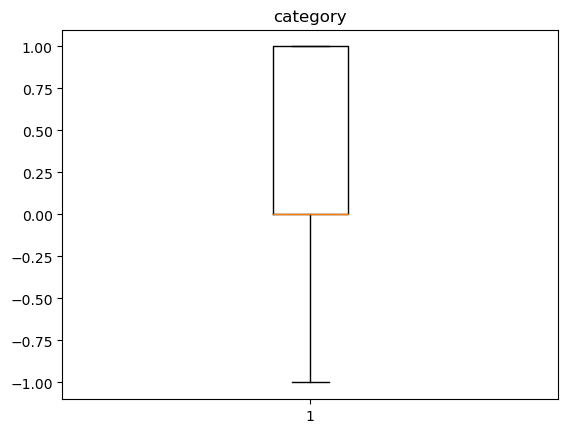

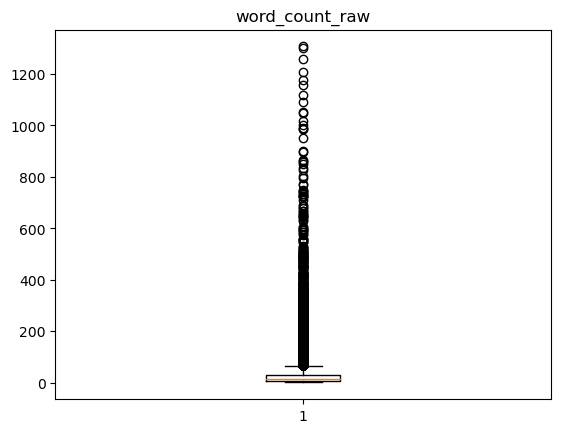

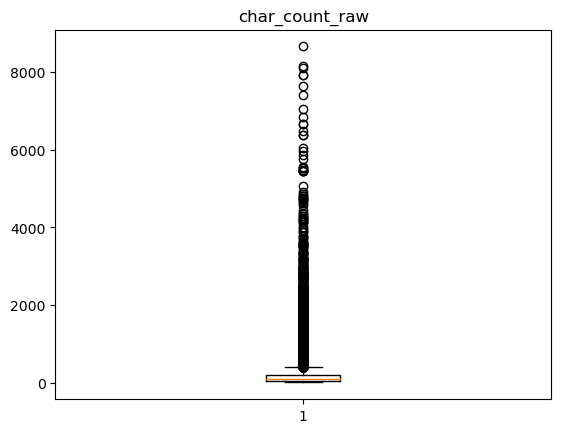

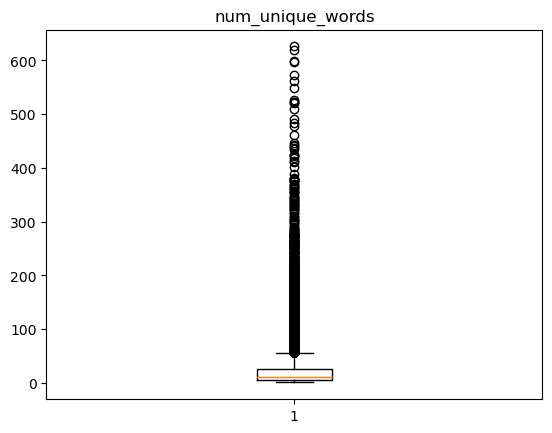

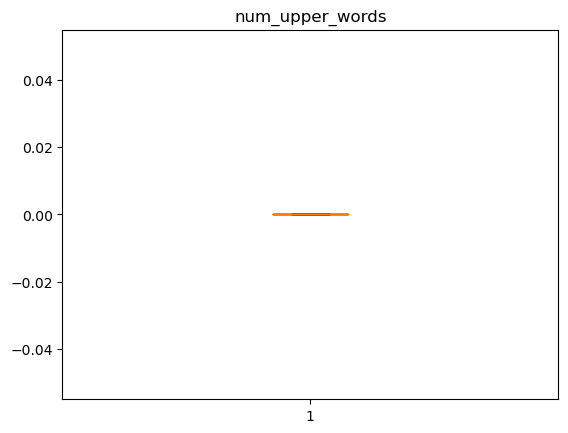

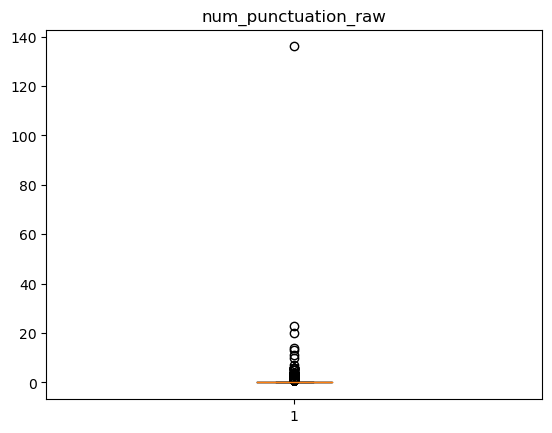

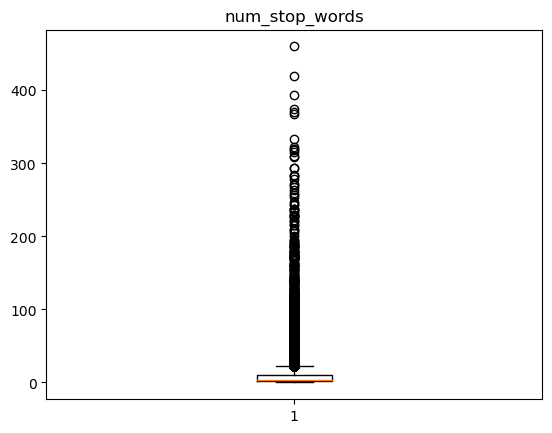

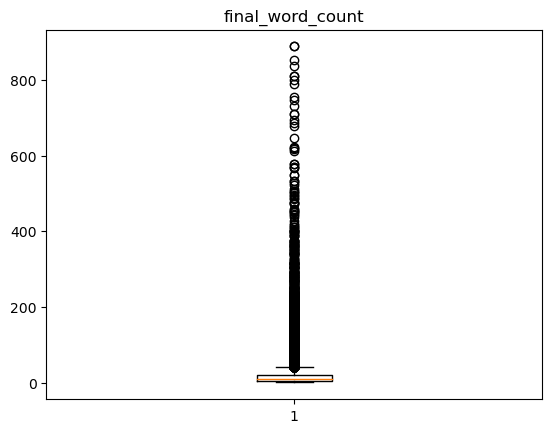

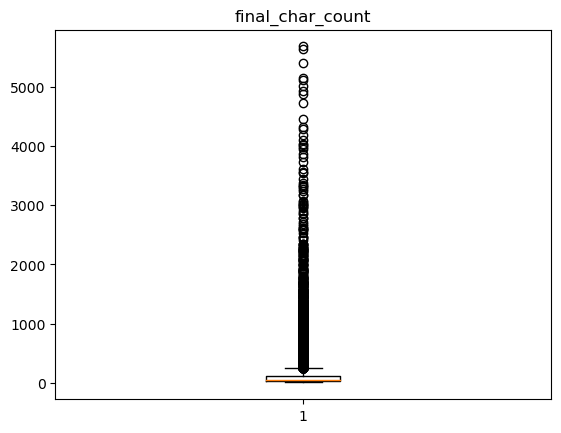

In [38]:
for col in df.columns:
  if df[col].dtype != "object":
    plt.boxplot(df[col])
    plt.title(col)
    plt.show()

## 5). EDA - Exploratory Data Analysis

#### a. Descriptive Statistics

In [41]:
df.describe()

,category,word_count_raw,char_count_raw,num_unique_words,num_upper_words,num_punctuation_raw,num_stop_words,final_word_count,final_char_count
count,36640.000000,36640.000000,36640.000000,36640.000000,36640.0,36640.000000,36640.000000,36640.000000,36640.000000
mean,0.205295,29.760944,183.655213,23.076474,0.0,0.022298,9.712418,19.998390,115.361927
std,0.783188,56.881985,360.362615,34.309867,0.0,0.765976,18.876912,38.801874,232.931781
min,-1.000000,1.000000,3.000000,1.000000,0.0,0.000000,0.000000,1.000000,2.000000
25%,0.000000,6.000000,39.000000,6.000000,0.0,0.000000,2.000000,5.000000,25.000000
50%,0.000000,13.000000,81.000000,12.000000,0.0,0.000000,4.000000,9.000000,51.000000
75%,1.000000,30.000000,186.000000,26.000000,0.0,0.000000,10.000000,20.000000,115.000000
max,1.000000,1307.000000,8665.000000,626.000000,0.0,136.000000,460.000000,888.000000,5688.000000


#### b. Visualization

In [43]:
import matplotlib.pyplot as plt
import seaborn           as sns

    * distribution of classes

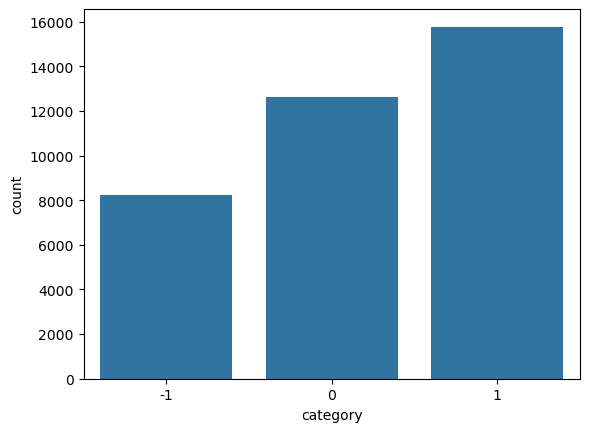

In [45]:
sns.countplot(data=df, x="category")
plt.show()

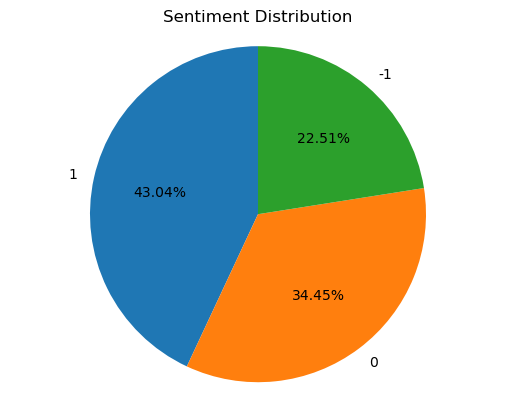

In [46]:
category_counts = df["category"].value_counts()

plt.pie(
            category_counts,
            labels     = category_counts.index,   # Ensures labels match the slice order
            autopct    = '%1.2f%%',
            startangle = 90                       # Optional: rotates chart for better layout
       )
plt.title("Sentiment Distribution")
plt.axis('equal')                                 # Ensures pie is a perfect circle
plt.show()

    * Boxplot: Word Count Distribution by Sentiment Category

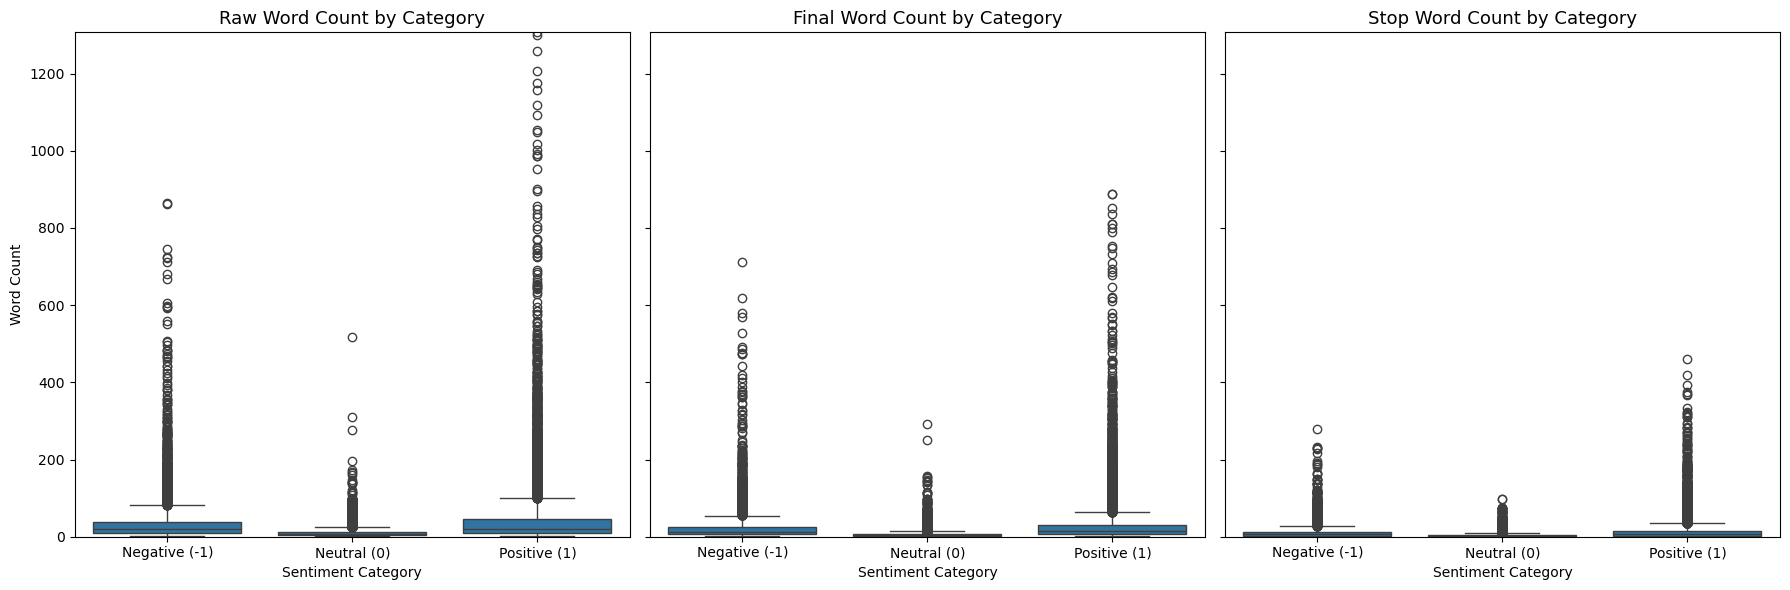

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define readable labels and order
label_map = {-1: 'Negative (-1)', 0: 'Neutral (0)', 1: 'Positive (1)'}
x_order   = [-1, 0, 1]
x_labels  = [label_map[i] for i in x_order]

# Find max y-value across all features
y_max = max(
                df['word_count_raw']    .max(),
                df['final_word_count']  .max(),
                df['num_stop_words']    .max()
           )

# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Boxplot 1️⃣: Initial Word Count
sns.boxplot(data=df, x='category', y='word_count_raw', ax=axes[0], order=x_order)
axes[0].set_title('Raw Word Count by Category', fontsize=13)
axes[0].set_xlabel('Sentiment Category')
axes[0].set_ylabel('Word Count')
axes[0].set_ylim(0, y_max)
axes[0].set_xticks(range(len(x_order)))
axes[0].set_xticklabels(x_labels)

# Boxplot 2️⃣: Final Word Count
sns.boxplot(data=df, x='category', y='final_word_count', ax=axes[1], order=x_order)
axes[1].set_title('Final Word Count by Category', fontsize=13)
axes[1].set_xlabel('Sentiment Category')
axes[1].set_ylabel('Word Count')
axes[1].set_ylim(0, y_max)
axes[1].set_xticks(range(len(x_order)))
axes[1].set_xticklabels(x_labels)

# Boxplot 3️⃣: Number of Stop Words
sns.boxplot(data=df, x='category', y='num_stop_words', ax=axes[2], order=x_order)
axes[2].set_title('Stop Word Count by Category', fontsize=13)
axes[2].set_xlabel('Sentiment Category')
axes[2].set_ylabel('Word Count')
axes[2].set_ylim(0, y_max)
axes[2].set_xticks(range(len(x_order)))
axes[2].set_xticklabels(x_labels)

# Final layout
plt.tight_layout()
plt.show()

    * Scatter Plot : Boxplot: Word Count Distribution by Sentiment Category

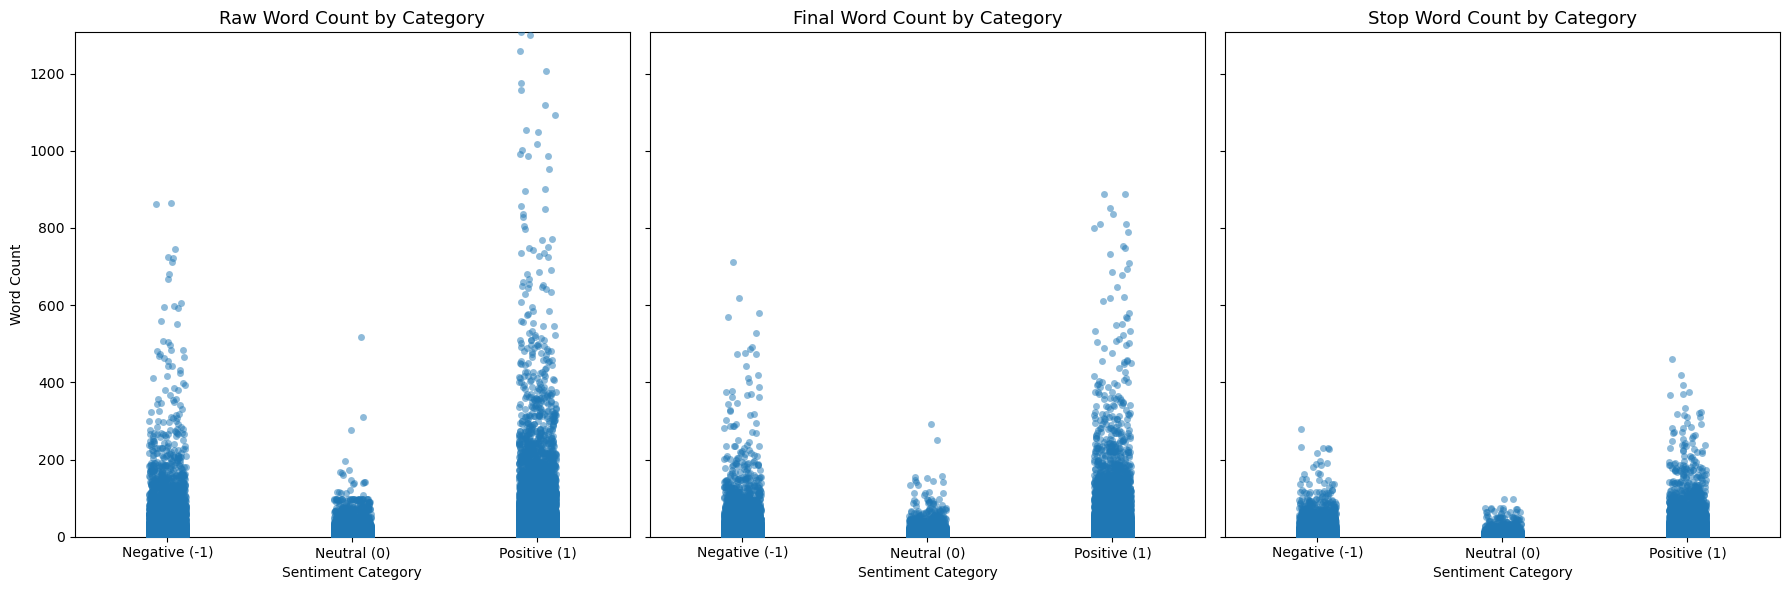

In [50]:
# Define readable labels and order
label_map = {-1: 'Negative (-1)', 0: 'Neutral (0)', 1: 'Positive (1)'}
x_order   = [-1, 0, 1]
x_labels  = [label_map[i] for i in x_order]

# Find max y-value across all features
y_max = max(
             df['word_count_raw'].max(),
             df['final_word_count']  .max(),
             df['num_stop_words']    .max()
           )

# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Scatter Plot 1️⃣: Initial Word Count
sns.stripplot(data=df, x='category', y='word_count_raw', ax=axes[0], order=x_order, jitter=True, alpha=0.5)
axes[0].set_title('Raw Word Count by Category', fontsize=13)
axes[0].set_xlabel('Sentiment Category')
axes[0].set_ylabel('Word Count')
axes[0].set_ylim(0, y_max)
axes[0].set_xticks(range(len(x_order)))
axes[0].set_xticklabels(x_labels)

# Scatter Plot 2️⃣: Final Word Count
sns.stripplot(data=df, x='category', y='final_word_count', ax=axes[1], order=x_order, jitter=True, alpha=0.5)
axes[1].set_title('Final Word Count by Category', fontsize=13)
axes[1].set_xlabel('Sentiment Category')
axes[1].set_ylabel('Word Count')
axes[1].set_ylim(0, y_max)
axes[1].set_xticks(range(len(x_order)))
axes[1].set_xticklabels(x_labels)

# Scatter Plot 3️⃣: Number of Stop Words
sns.stripplot(data=df, x='category', y='num_stop_words', ax=axes[2], order=x_order, jitter=True, alpha=0.5)
axes[2].set_title('Stop Word Count by Category', fontsize=13)
axes[2].set_xlabel('Sentiment Category')
axes[2].set_ylabel('Word Count')
axes[2].set_ylim(0, y_max)
axes[2].set_xticks(range(len(x_order)))
axes[2].set_xticklabels(x_labels)

# Final layout
plt.tight_layout()
plt.show()

    * KDE Distribution of Initial_word_count, final_word_count, num_stop_words

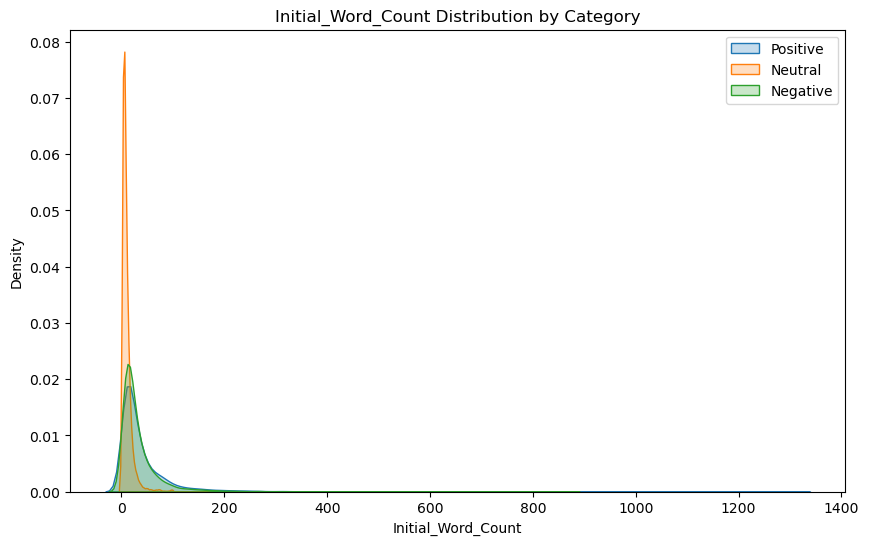

In [52]:
plt.figure(figsize=(10, 6))   # Create the figure and axes

sns.kdeplot(df[df['category'] ==  1]['word_count_raw'], label='Positive', fill=True) # Plot KDE for category  1
sns.kdeplot(df[df['category'] ==  0]['word_count_raw'], label='Neutral',  fill=True) # Plot KDE for category  0
sns.kdeplot(df[df['category'] == -1]['word_count_raw'], label='Negative', fill=True) # Plot KDE for category -1

# Add title and labels
plt.title('Initial_Word_Count Distribution by Category')
plt.xlabel('Initial_Word_Count')
plt.ylabel('Density')

plt.legend()   # Add a legend
plt.show()     # Show the plot

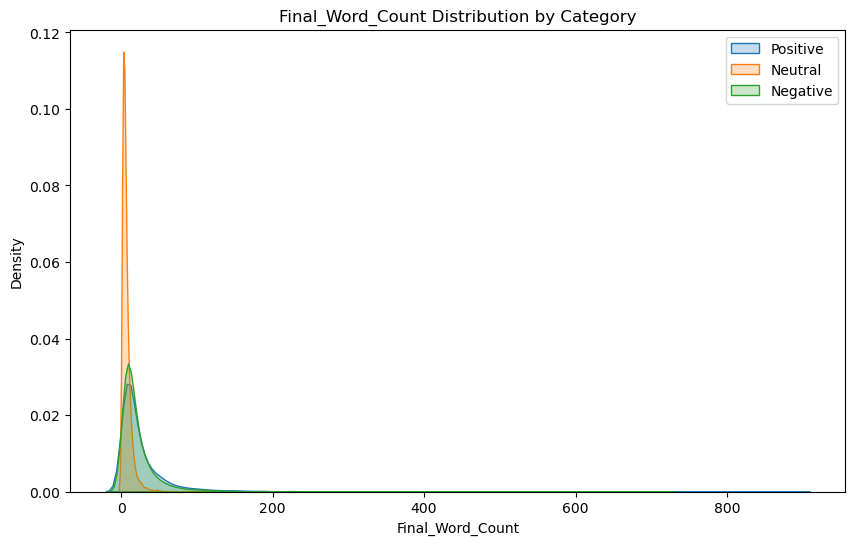

In [53]:
plt.figure(figsize=(10, 6))   # Create the figure and axes

sns.kdeplot(df[df['category'] ==  1]['final_word_count'], label='Positive', fill=True) # Plot KDE for category  1
sns.kdeplot(df[df['category'] ==  0]['final_word_count'], label='Neutral',  fill=True) # Plot KDE for category  0
sns.kdeplot(df[df['category'] == -1]['final_word_count'], label='Negative', fill=True) # Plot KDE for category -1

# Add title and labels
plt.title('Final_Word_Count Distribution by Category')
plt.xlabel('Final_Word_Count')
plt.ylabel('Density')

plt.legend()   # Add a legend
plt.show()     # Show the plot

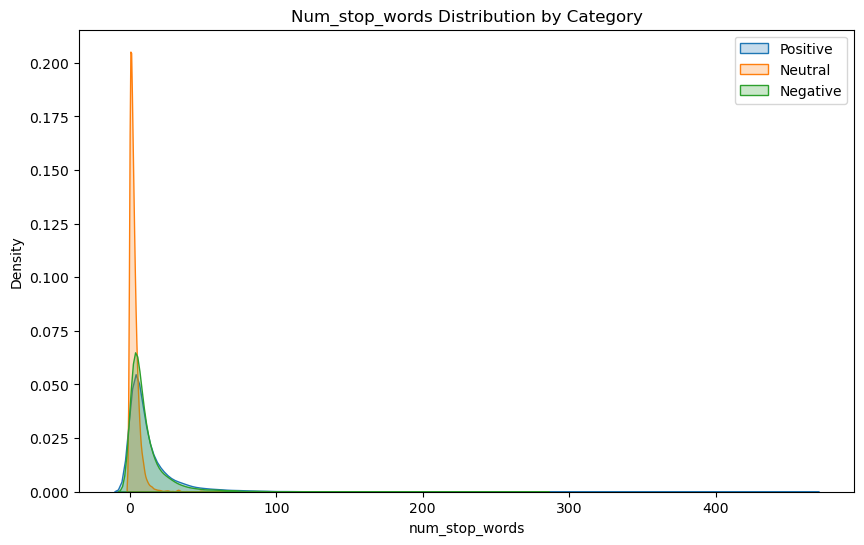

In [54]:
plt.figure(figsize=(10, 6))   # Create the figure and axes

sns.kdeplot(df[df['category'] ==  1]['num_stop_words'], label='Positive', fill=True) # Plot KDE for category  1
sns.kdeplot(df[df['category'] ==  0]['num_stop_words'], label='Neutral',  fill=True) # Plot KDE for category  0
sns.kdeplot(df[df['category'] == -1]['num_stop_words'], label='Negative', fill=True) # Plot KDE for category -1

# Add title and labels
plt.title('Num_stop_words Distribution by Category')
plt.xlabel('num_stop_words')
plt.ylabel('Density')

plt.legend()   # Add a legend
plt.show()     # Show the plot

#### Insights from the Three KDE Distributions

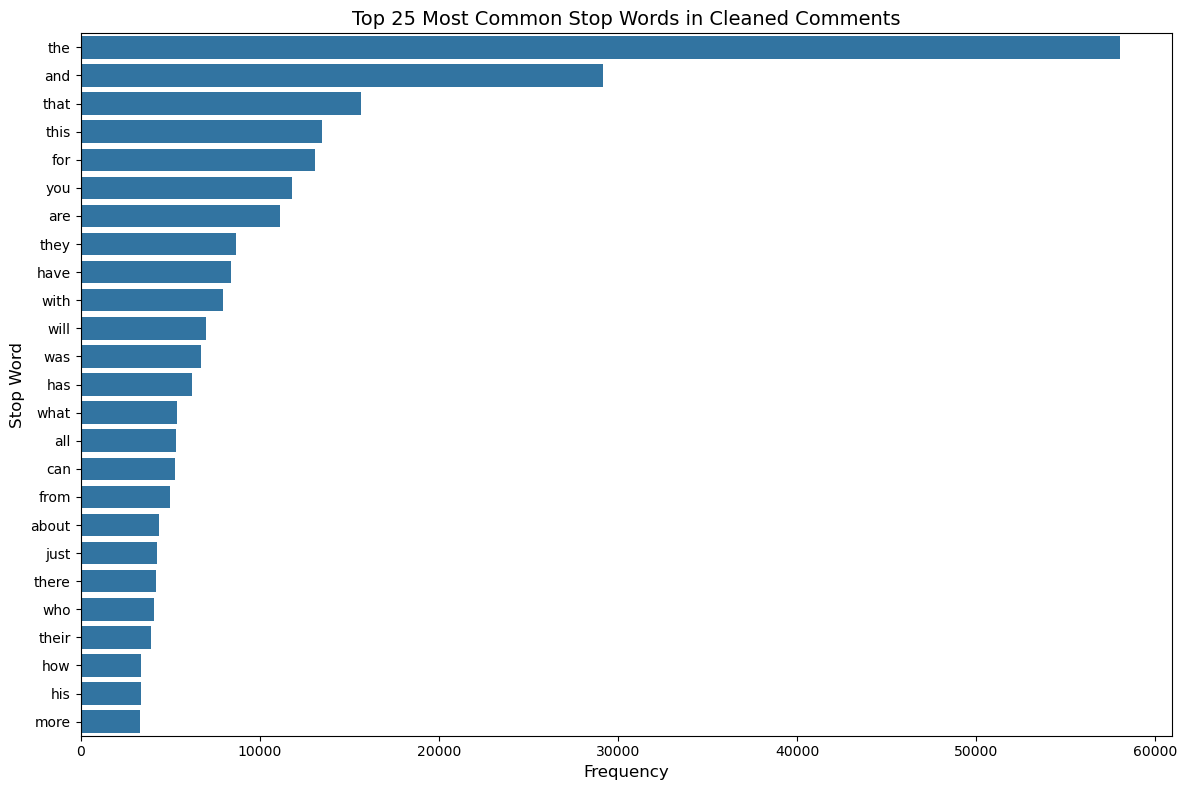

In [56]:
# Step 1 : Extract stop words from each comment
all_stop_words = [
                    word for comment in df['cleaned_comment']
                    for word in comment.split()
                    if  word in stop_words
                 ]

# Step 2️ : Count the top 25 most frequent stop words
top_25    = Counter(all_stop_words).most_common(25)
top_25_df = pd.DataFrame(top_25, columns=['Stop Word', 'Frequency'])

# step 3 : Plot the frequencies
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_df, x='Frequency', y='Stop Word')
plt.title('Top 25 Most Common Stop Words in Cleaned Comments', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Stop Word', fontsize=12)

plt.tight_layout()
plt.show()

## N-grams

### 🔍 Understanding N-grams in NLP

**N-grams** are sequences of *n* consecutive words used to capture local word patterns and context in text. They help models understand how words relate to each other beyond individual tokens.

- **Unigram**: A single word — basic unit of text.
- **Bigram**: A pair of consecutive words — captures short phrases and word relationships.  
  _Examples_: `"not good"`, `"New York"`
- **Trigram**: A sequence of three consecutive words — captures richer context and common expressions.  
  _Examples_: `"I love you"`, `"machine learning model"`

**Example Sentence**:  
`"The movie was not good"`

| N-gram Type | Extracted Tokens |
|-------------|------------------|
| Unigrams    | `["The", "movie", "was", "not", "good"]`  
| Bigrams     | `[("The", "movie"), ("movie", "was"), ("was", "not"), ("not", "good")]`  
| Trigrams    | `[("The", "movie", "was"), ("movie", "was", "not"), ("was", "not", "good")]`  

---

### 🧠 Why N-grams Are Useful in NLP

- **Preserve Context**: `"not good"` carries a negative tone that `"good"` alone would miss.
- **Improve Sentiment Detection**: Trigrams like `"I am happy"` or `"this is terrible"` offer stronger emotional signals.
- **Enhance Feature Richness**: Capture common phrases, idioms, and domain-specific expressions.
- **Boost Classification Accuracy**: Especially helpful in short texts where single words may be ambiguous.
- **Support Language Modeling**: Predict next words based on previous ones — useful in autocomplete and chatbots.

---


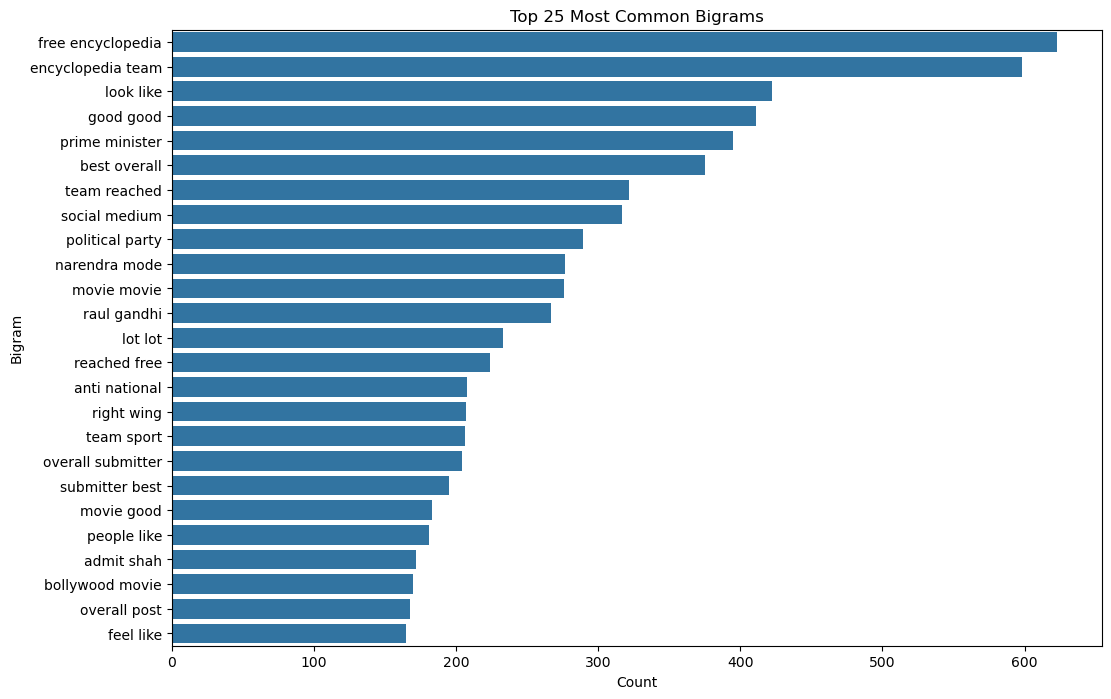

In [59]:
from sklearn.feature_extraction.text import CountVectorizer

# function to extract the top 25 bigrams
def get_top_ngrams(corpus, n=None):
    vec           = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words  = vec.transform(corpus)
    sum_words     = bag_of_words.sum(axis=0)
    words_freq    = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq    = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    return words_freq[:n]

# Get the top 25 bigrams
top_25_bigrams    = get_top_ngrams(df['processed_comment'], 25)

# Convert the bigrams into a DataFrame for plotting
top_25_bigrams_df = pd.DataFrame(top_25_bigrams, columns=['bigram', 'count'])

# Plot the countplot for the top 25 bigrams
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_bigrams_df, x='count', y='bigram')
plt.title('Top 25 Most Common Bigrams')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show()

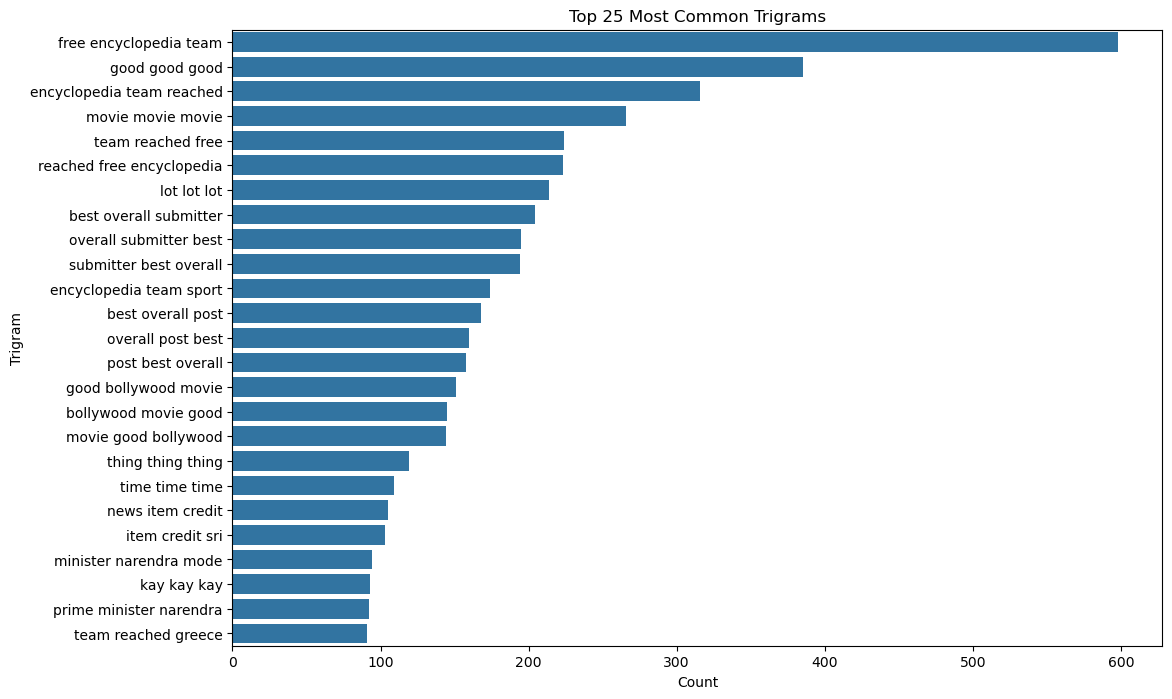

In [60]:
# function to extract the top 25 trigrams
def get_top_trigrams(corpus, n=None):
    vec            = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words   = vec.transform(corpus)
    sum_words      = bag_of_words.sum(axis=0)
    words_freq     = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq     = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    return words_freq[:n]

# Get the top 25 trigrams
top_25_trigrams    = get_top_trigrams(df['processed_comment'], 25)

# Convert the trigrams into a DataFrame for plotting
top_25_trigrams_df = pd.DataFrame(top_25_trigrams, columns=['trigram', 'count'])

# Plot the countplot for the top 25 trigrams
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_trigrams_df, x='count', y='trigram')
plt.title('Top 25 Most Common Trigrams')
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.show()

### Character Frequency Analysis

In [62]:
all_text         = ' '.join(df['raw_comment'])
# Count the frequency of each character
char_freq_raw    = Counter(all_text)
# Convert the character frequency into a DataFrame for better display
char_freq_raw_df = pd.DataFrame(char_freq_raw.items(), columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)

char_freq_raw_df

,character,frequency
0,,1132139
12,e,666431
13,t,491161
2,a,481042
4,i,401335
...,...,...
877,顶,1
875,错,1
371,ഞ,1
872,首,1


In [63]:
all_text           = ' '.join(df['processed_comment'])
# Count the frequency of each character
char_freq_final    = Counter(all_text)
# Convert the character frequency into a DataFrame for better display
char_freq_final_df = pd.DataFrame(char_freq_final.items(), columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)

char_freq_final_df

,character,frequency
6,,732740
10,e,501602
1,a,356875
3,i,332135
12,t,320734
9,n,316428
7,o,294235
8,r,267436
16,s,218296
4,l,217401


#### Character Frequency Insights
- `Language Profile`: We get a fingerprint of the dataset’s writing style. For example, high frequency of spaces and vowels suggests natural language; high frequency of symbols or digits might indicate code, spam, or structured data.
- `Noise Detection`: Rare or unexpected characters (like @, #, ~, or non-ASCII symbols) can reveal formatting issues, encoding errors, or unwanted tokens that should be cleaned.
- `Custom Tokenization`: If we're building a character-level model (e.g. CNN for text or OCR), this helps us decide which characters to include in your vocabulary and which to discard.
- `Compression & Encoding`: Understanding which characters dominate lets us optimize storage or encoding schemes — useful in low-resource deployments.
- `Corpus Comparison`: We can compare character distributions across datasets (e.g., tweets vs. reviews vs. transcripts) to understand stylistic or domain differences

### Word_Cloud

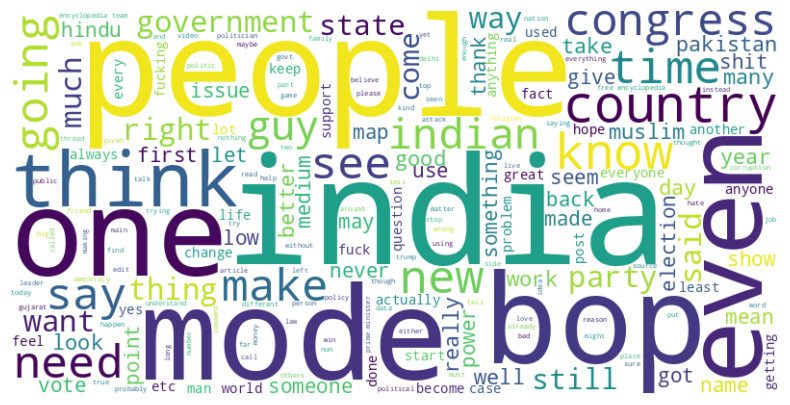

In [66]:
from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(df['processed_comment'])

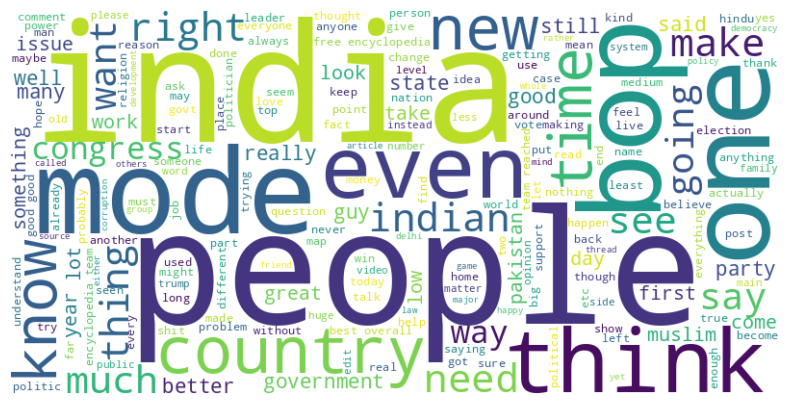

In [67]:
plot_word_cloud(df[df['category'] == 1]['processed_comment'])

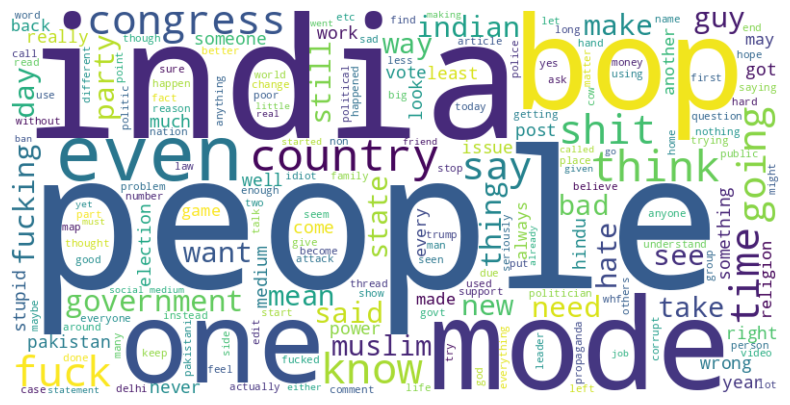

In [68]:
plot_word_cloud(df[df['category'] == -1]['processed_comment'])

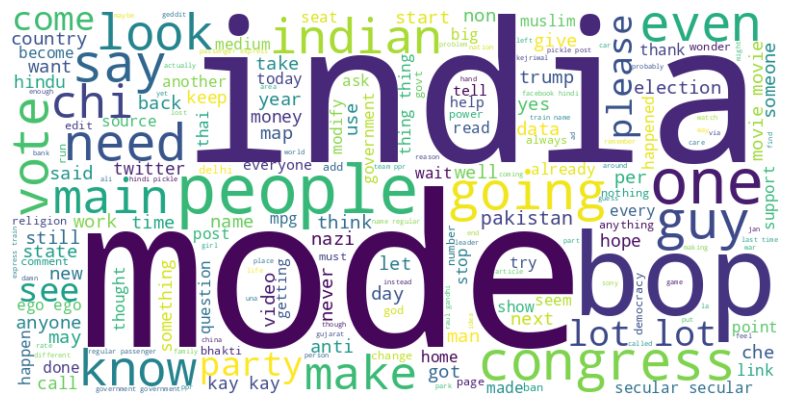

In [69]:
plot_word_cloud(df[df['category'] == 0]['processed_comment'])

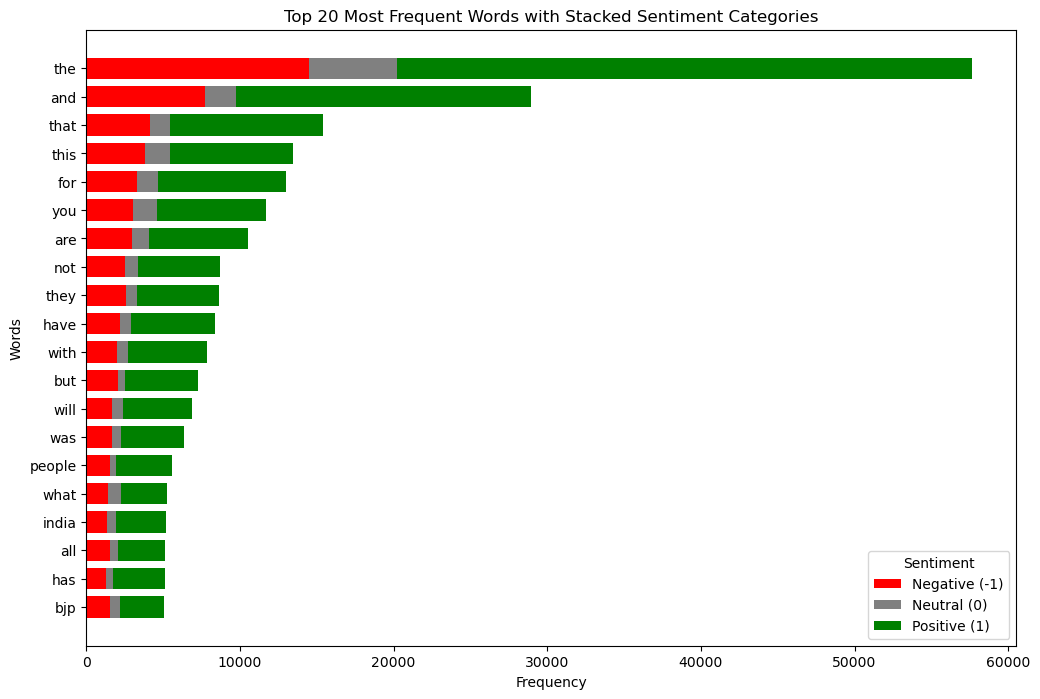

In [70]:
def plot_top_n_words_by_category(df, column_name, n=20, start=0):
    """Plot the top N most frequent words in the dataset with stacked hue based on sentiment category."""
    # Flatten all words in the content column and count their occurrences by category
    word_category_counts = {}

    for idx, row in df.iterrows():
        words    = row[column_name].split()
        category = row['category']                                  # Assuming 'category' column exists for -1, 0, 1 labels

        for word in words:
            if word not in word_category_counts:
                word_category_counts[word] = { -1: 0, 0: 0, 1: 0 }  # Initialize counts for each sentiment category
            
            word_category_counts[word][category] += 1              # Increment the count for the corresponding sentiment category

    # Get total counts across all categories for each word
    total_word_counts = {word: sum(counts.values()) for word, counts in word_category_counts.items()}

    # Get the top N most frequent words across all categories
    most_common_words = sorted(total_word_counts.items(), key=lambda x: x[1], reverse=True)[start:start+n]
    top_words         = [word for word, _ in most_common_words]

    # Prepare data for plotting
    word_labels       = top_words
    negative_counts   = [word_category_counts[word][-1] for word in top_words]
    neutral_counts    = [word_category_counts[word][0]  for word in top_words]
    positive_counts   = [word_category_counts[word][1]  for word in top_words]

    # Plot the stacked bar chart
    plt.figure(figsize=(12, 8))
    bar_width         = 0.75

    # Plot negative, neutral, and positive counts in a stacked manner
    plt.barh(word_labels, negative_counts, color='red', label='Negative (-1)', height=bar_width)
    plt.barh(word_labels, neutral_counts,  left=negative_counts, color='gray', label='Neutral (0)', height=bar_width)
    plt.barh(word_labels, positive_counts, left=[i+j for i,j in zip(negative_counts, neutral_counts)], color='green', label='Positive (1)', height=bar_width)

    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {n} Most Frequent Words with Stacked Sentiment Categories')
    plt.legend(title='Sentiment', loc='lower right')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest frequency at the top
    plt.show()


plot_top_n_words_by_category(df[["raw_comment", "category"]],column_name = "raw_comment", n=20)


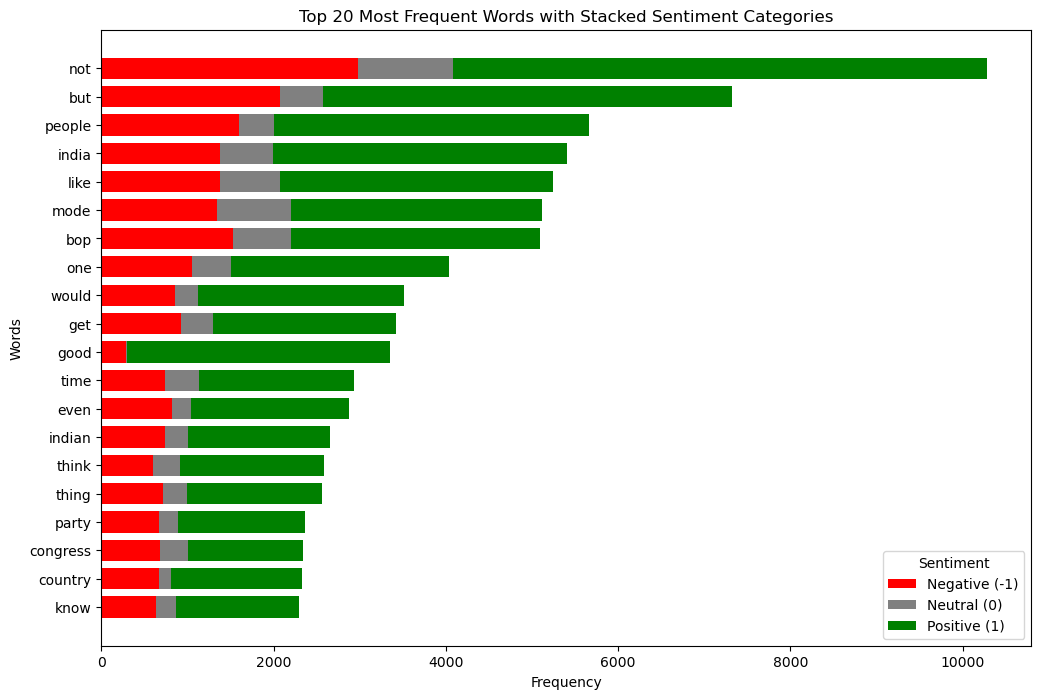

In [71]:
plot_top_n_words_by_category(df[["processed_comment", "category"]], column_name="processed_comment", n=20)

In [72]:
df.head()

,raw_comment,category,word_count_raw,char_count_raw,num_unique_words,num_upper_words,num_punctuation_raw,cleaned_comment,num_stop_words,processed_comment,final_word_count,final_char_count
0,family mormon have never tried explain them t...,1,39,261,34,0,0,family mormon have never tried explain them th...,13,family mormon never tried explain still stare ...,26,171
1,buddhism has very much lot compatible with chr...,1,196,1269,136,0,0,buddhism has very much lot compatible with chr...,56,buddhism much lot compatible christianity espe...,140,842
2,seriously don say thing first all they won get...,-1,86,460,67,0,0,seriously don say thing first all they won get...,40,seriously say thing first get complex explain ...,46,230
3,what you have learned yours and only yours wha...,0,29,168,24,0,0,what you have learned yours and only yours wha...,14,learned want teach different focus goal not wr...,15,87
4,for your own benefit you may want read living ...,1,112,691,82,0,0,for your own benefit you may want read living ...,46,benefit may want read living buddha living chr...,66,397


In [73]:
df.to_csv("preprocessed_corpus.csv", index=False)